#**Agent Plan-and-Execute**

Neste notebook, exploraremos um exemplo da arquitetura de agente "Plan-and-Execute". Nesse modelo, o agente elabora um plano detalhado, dividido em etapas que devem ser seguidas para alcançar um objetivo específico. A cada etapa executada, o agente verifica se o objetivo já foi atingido; caso positivo, ele encerra a execução e informa o usuário. O objetivo será fornecido como entrada pelo usuário.

<br>

A arquitetura de agente "Plan-and-Execute" é projetada para permitir que agentes autônomos alcancem objetivos de forma estruturada e eficiente. Esse tipo de arquitetura visa fornecer ao agente a capacidade de criar um plano de ação passo a passo, o que facilita a realização de tarefas complexas que exigem uma sequência lógica de ações. Com essa abordagem, o agente não apenas executa ações de forma reativa, mas também se planeja com antecedência, considerando as etapas necessárias para atingir o objetivo.

## Configurações

Vamos instalar os módulos necessários e configurar as variáveis de ambiente.

In [ ]:
pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49

In [3]:
from google.colab import userdata
import os

OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
TAVILY_API_KEY = userdata.get("TAVILY_API_KEY")

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

## Tools

Neste exemplo vamos utilizar somente a tool do Tavily, ele irá realizar pesquisas na internet para auxiliar o agente na realização de cada etapa.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

## Definindo a clase de estado do Workflow

Vamos desenvolver a classe 'PlanExecute' ele será o nosso State no Workflow, responsável por gerenciar e interagir com os input e outputs de cada node.

In [6]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
  input: str
  plan: List[str]
  past_steps: Annotated[List[Tuple], operator.add]
  response: str

## Agent Executor

Vamos utilizar um agent do tipo reAct, ele irá interagir com as ferramentas disponíveis conforme ele entender que haja necessidade.
Neste exemplo, vamos utilizar um prompt do próprio hub de prompts do Langchain.

In [5]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

##Utilizando prompt do hub de prompts do langchain
prompt =  hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

llm = ChatOpenAI(model = "gpt-4o-mini")
agent_executor = create_react_agent(model= llm, tools= tools, state_modifier= prompt)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


## Planejador de Etapas

Vamos desenvolver o `planner`, que irá criar um plano inicial para atingir um determinado objetivo. Ele irá devolver um output estruturado a partir da `class Plan`.

In [7]:
from pydantic import BaseModel, Field

class Plan(BaseModel):
  "Planeje as próximas etapas a seguir"

  steps: List[str] = Field(
      description = "As diferentes etapas a seguir, devem estar por ordem de classificação"
  )

In [8]:
from  langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Para um objetivo informado, elabore um plano etapa a etapa simples.
            Este plano deve envolver tarefas individuais que se executadas corretamente
            produzirão a resposta correta. Não adicione etapas supérfluas.
            Certifique-se de que tenha todas as informações necessárias para cada etapa - Não pule etapas.
            O resultado da etapa final deve ser o a resposta final.
            """
        ),
        ("placeholder", "{messages}"),
    ]
)

llm_with_structured_output = ChatOpenAI(model= "gpt-4o-mini", temperature= 0).with_structured_output(Plan)

planner = planner_prompt | llm_with_structured_output

## Replanejador de Etapas

Vamos desenvolver o `replanner`, ele será responsável por avaliar o plano original e identificar se já atingimos o objetivo, caso ele entenda que ainda não foi atingido irá ou remover as etapas já realizadas ou desenvolver novas etapas para serem inseridas no plano original.

O `replanner` também terá um output estruturado, á partir da classe `Act`, que terá uma variável chamda `action` que terá o seu type definido como um `Response` ou `Plan`. É com está lógica que vamos conseguir identificar quando o o replanejador identificar que já atingiu o seu objetivo final.

In [63]:
from typing import Union

class Response(BaseModel):
  "A resposta para o usuário"
  response: str

class Act(BaseModel):
  "Ação a ser executada"

  action: Union[Response,Plan] = Field(
      description =
      "Ação a ser realizada. Se você já tiver a resposta do input do usuário utilize 'RESPONSE'"
      "Se você precisar usar mais ferramentas para obter a resposta, use 'PLAN'"
  )

replanner_prompt = ChatPromptTemplate.from_template(
    """
    Para um objetivo informado, análise o seu plano atual e avalie se é necessário muda-lo ou não.
    Identifique se já conseguimos atingir o objetivo através das etapas anteriores em 'past_steps', caso já tenha conseguido a resposta final utilize o RESPONSE e responda a pergunta do usuário.

    Caso voce identifique que ainda precisamos seguir as outras etapas, analise o plano original e remova as etapas que já foram realizadas. Você também poderá adicionar novas etapas, caso tenha necessidade.

    Se o plano sofrer alterações, se lembre que ele deve envolver tarefas individuais que se executadas corretamente produzirão a resposta correta. Não adicione etapas supérfluas.

    Certifique-se de que tenha todas as informações necessárias para cada etapa.

    O seu objetivo será o seguinte:
    {input}

    O seu plano original era este:
    {plan}

    Atualmente você já executou as seguintes etapas:
    {past_steps}

    """
)

llm_with_structured_output = ChatOpenAI(model= "gpt-4o-mini", temperature= 0).with_structured_output(Act)

replanner = replanner_prompt | llm_with_structured_output

## Criação dos Nodes

Vamos iniciar a criação dos nodes que será incluidos no workflow.

* `execute_step_node`: Será o responsável por informar o agent_executor qual é o plano e a tarefa atual que precisa ser executada. Ele também irá salvar a tarefa atual, na lista de tarefas já realizadas.

<br>

* `plan_step_node`: Este será o node de entrada, responsável por coletar o input do usuário e inserir ao planner, que irá criar um plano para atingir o objetivo informado na entrada do usuário.

<br>

* `replan_step_node`: O node será responsável por informar ao replanner qual é o status atual envolvendo o objetivo, caso ele entenda que já concluído irá formatar um response para o usuário, caso o contrário ele irá seguir com o plano atual ou adicionar novas etapas ao plano.

In [64]:
from typing import Literal
from langgraph.graph import END

async def execute_step_node(state: PlanExecute):
  plan = state["plan"]
  plan_str = "\n".join(f"{1+i}. {step}" for i,step in enumerate(plan))
  task = plan[0]
  task_formatted = f"""Para o seguinte plano:{plan_str}
  \n\n Você está encarregado de executar a etapa {1}, {task}"""

  agent_response = await agent_executor.ainvoke({
      'messages': ['user',task_formatted]
  })

  return {
      'past_steps': [(task, agent_response['messages'][-1].content)]
  }

async def plan_step_node(state: PlanExecute):
  plan = await planner.ainvoke({'messages': [('user', state['input'])]})

  return {'plan': plan.steps}

async def replan_step_node(state: PlanExecute):
  output = await replanner.ainvoke(state)

  if isinstance(output.action, Response):
    return {"response": output.action.response}

  else:
    return {'plan': output.action.steps}

## Criação do Edge Conditional

Função responsável por identificar se já foi gerado um response o não.

In [ ]:
def should_end_conditional(state: PlanExecute):
  if 'response' in state and state['response']:
    return END

  else:
    return 'agent'

## Inicializando o Graph

Inicializando o Graph e inserindo os seus nodes, definindo os seus edges e conditional edges.

In [65]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

## Add nodes
workflow.add_node('planner', plan_step_node)
workflow.add_node('agent', execute_step_node)
workflow.add_node('replan', replan_step_node)

##Add edges
workflow.add_edge(START, 'planner')
workflow.add_edge('planner', 'agent')
workflow.add_edge('agent', 'replan')

##Add conditional edge
workflow.add_conditional_edges(
    'replan',
    should_end_conditional,
    ['agent', END]
)

In [66]:
##Compilando o graph
app = workflow.compile()

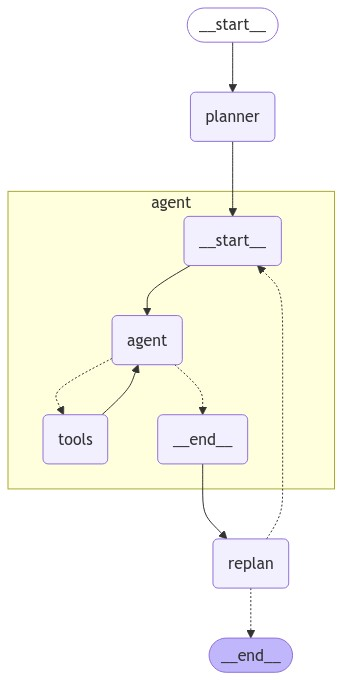

In [67]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Testando o Agent Plan-and-Execute

Vamos realizar alguns teste envolvendo perguntas mais complexas e analisar como ele está desenvolvendo o seu plano inicial e analisando os próximos passos.

In [69]:
config = {"recursion_limit": 50}
inputs = {"input": "Quem é Renato Portaluppi e qual o seu maior feito na história do Gremio?"}

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identificar quem é Renato Portaluppi.', 'Pesquisar a carreira de Renato Portaluppi como jogador e treinador.', 'Identificar os principais títulos conquistados por Renato Portaluppi no Grêmio.', 'Determinar qual é considerado o maior feito de Renato Portaluppi na história do Grêmio.']}
{'past_steps': [('Identificar quem é Renato Portaluppi.', 'Renato Portaluppi, conhecido como Renato Gaúcho, é um renomado treinador e ex-jogador de futebol brasileiro. Ele atuava como ponta-direita e é amplamente reconhecido por sua carreira tanto como jogador quanto como treinador.\n\nRenato é famoso por suas conquistas no Grêmio, onde teve um papel destacado como jogador, sendo um dos maiores artilheiros da história do clube. Ele também se destacou por sua atuação na seleção brasileira. Além disso, Renato Portaluppi fez história ao vencer a Copa Libertadores tanto como jogador quanto como treinador do Grêmio, consolidando-se como uma figura icônica no futebol brasileiro.\n\nSe você precisar d